In [6]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt


print('Start data preprocessing...')
data = pd.read_csv("fer2013.csv", delimiter=',')

#getting features and labels 
d_X = data['pixels'].values
dataY = data['emotion'].values

lenth, width = 48, 48

dataX = []
for seq in d_X:
    x = [float(i) for i in seq.split(' ')]
    x = np.array(x).reshape(lenth, width)
    dataX.append(x)

dataX = np.array(dataX)

print('saving data to dataX.npy, dataY.npy...')
if(len(dataX)==0 or len(dataY)==0):
    raise AssertionError('There is no images inside!')
np.save('dataX', dataX)
np.save('dataY', dataY)

print('data features shape:', dataX.shape)
print('data labels shape:', dataY.shape)

Start data preprocessing...
saving data to dataX.npy, dataY.npy...
data features shape: (35887, 48, 48)
data labels shape: (35887,)


In [23]:
import cv2
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import os.path, os
import numpy as np
import pickle
from skimage import io

def Sift_extraction(images):
    print(images.shape)
    #extract sift descriptos of image
    desc = []
    flag = 'Image file found!'
    if not os.path.exists('pics'):
        flag = 'Writing images...'
        os.makedirs('pics')
    print(flag)

    for idx in range(len(images)):
        filepath = 'pics/'+str(idx)+'.jpg'
        if (flag =='Writing images...'):
            cv2.imwrite(filepath, images[idx])
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            for d in des:
                 desc.append(d)
    print('SIFT descriptors ready to cluster...')

    #KMeans clusting
    k = 2048
    print('clustering..')
    kmeans = MiniBatchKMeans(n_clusters=k, max_iter = 200, batch_size=k*2,
        max_no_improvement=30, verbose=1).fit(desc)
    pickle.dump(kmeans, open('kmeans_model.sav', 'wb'))
    print("kMeans Model Saved!")
    load_Kmeans()

#Load kMeans clustering
def load_Kmeans():
    kmeans =pickle.load(open('kmeans_model.sav', 'rb'))
    print('kMeans Model loaded...')
    kmeans.verbose=False
    histo_list = []
    for idx in range(len(images)):
        print(idx)
        filepath = 'pics/'+str(idx)+'.jpg'
        img = cv2.imread(filepath)
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(img, None)
        k=2048
        histo = np.zeros(k)
        nkp = np.size(kp)

        if des is not None:
            for d in des:
                idx = kmeans.predict([d])
                histo[idx] +=1/nkp
    
    histo_list.append(histo)
    print(np.array(histo_list).shape)
    np.save('sift_histogram', histo_list)
    print('sift_histogram saved!')


def DSift_extraction(images):
    print(images.shape)
    descriptors = []
    flag = 'Image file found!'
    if not os.path.exists('pics'):
        flag = 'Writing images...'
        os.makedirs('pics')
    print(flag)
    for idx in range(len(images)):
        #print(idx)
        filepath = 'pics/'+str(idx)+'.jpg'
        if(flag == 'Writing images...'):
            if not cv2.imwrite(filepath, images[idx]):
                raise Exception('cannot write image')
        img = cv2.imread(filepath)
        gray= cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()

        step_size = 12
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]

        dense_feat, desc = sift.compute(gray, kp)

        if desc is not None:
            desc = desc.flatten()
            descriptors.append(desc)

    np.save('d_sift', descriptors)
    print('d_sift saved!')

    return descriptors

initXyStep = 12
initFeatureScale = 12
initImgBound = 6

def detect(img):
    keypoints = []
    rows, cols = img.shape[:2]
    for x in range(initImgBound, rows, initFeatureScale):
        for y in range(initImgBound, cols, initFeatureScale):
            keypoints.append(cv2.KeyPoint(float(x), float(y), initXyStep))
    return keypoints 

#Dense SIFT feature extraction	
def DSift(images):
    desp = []
    flag = 'Image file found!'
    if not os.path.exists('pics'):
        flag = 'Writing images...'
        os.makedirs('pics')
    print(flag)
    for idx in range(len(images)):
        filepath = 'pics/'+str(idx)+'.jpg'
        if(flag == 'Writing images...'):
            if not cv2.imwrite(filepath, images[idx]):
                raise Exception('cannot write image')

        input_image = cv2.imread(filepath)
        keypoints = detect(input_image)

        sift = cv2.SIFT_create()
        dense_feat, desc = sift.compute(input_image, keypoints)
        
        temp = []
        for d in desc:
            for i in d:
                temp.append(i)
        desp.append(temp)
    print(np.array(desp).shape)
    np.save('d_sift', desp) 
    print('d_sift saved!')

    return desp


def checkfile():
    filepath = './pics'
    if os.path.exists('pics'):
        print('file exists!')
    else:
        print('no file')
    print(os.path.getsize('pics'))
    print(os.stat('./pics').st_size)

images = np.load('./dataX.npy')
DSift_extraction(images)
Sift_extraction(images)
load()
DSift(images)



(35887, 48, 48)
Image file found!
d_sift saved!
(35887, 48, 48)
Image file found!
SIFT descriptors ready to cluster...
clustering..


C:\Users\Dheeresh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=16
  warnings.warn(


Init 1/3 with method k-means++
Inertia for init 1/3: 1190983470.0
Init 2/3 with method k-means++
Inertia for init 2/3: 1187674047.0
Init 3/3 with method k-means++
Inertia for init 3/3: 1185950624.0
[MiniBatchKMeans] Reassigning 474 cluster centers.
Minibatch step 1/41783: mean batch inertia: 96339.8134765625
Minibatch step 2/41783: mean batch inertia: 84917.10381870074, ewa inertia: 84917.10381870074
Minibatch step 3/41783: mean batch inertia: 80601.11897203472, ewa inertia: 84875.78587687183
Minibatch step 4/41783: mean batch inertia: 78586.67528725456, ewa inertia: 84815.57873650196
Minibatch step 5/41783: mean batch inertia: 78359.82957812469, ewa inertia: 84753.77632577434
Minibatch step 6/41783: mean batch inertia: 76378.92823399755, ewa inertia: 84673.60192790793
Minibatch step 7/41783: mean batch inertia: 75708.93896845196, ewa inertia: 84587.78109307328
Minibatch step 8/41783: mean batch inertia: 75515.22223724295, ewa inertia: 84500.92734535123
Minibatch step 9/41783: mean bat

Minibatch step 83/41783: mean batch inertia: 69642.61715419982, ewa inertia: 77230.48414147222
Minibatch step 84/41783: mean batch inertia: 69738.7741177091, ewa inertia: 77158.76423281684
Minibatch step 85/41783: mean batch inertia: 69132.9834839711, ewa inertia: 77081.93153903005
[MiniBatchKMeans] Reassigning 14 cluster centers.
Minibatch step 86/41783: mean batch inertia: 68956.6974467517, ewa inertia: 77004.14675490822
Minibatch step 87/41783: mean batch inertia: 69136.04736218198, ewa inertia: 76928.82358196801
Minibatch step 88/41783: mean batch inertia: 68797.34272340819, ewa inertia: 76850.97899607787
Minibatch step 89/41783: mean batch inertia: 69434.65882735046, ewa inertia: 76779.98081230232
Minibatch step 90/41783: mean batch inertia: 68289.58557644144, ewa inertia: 76698.70025434793
Minibatch step 91/41783: mean batch inertia: 68758.62076147571, ewa inertia: 76622.6879989164
Minibatch step 92/41783: mean batch inertia: 69131.2834305347, ewa inertia: 76550.9710144575
Miniba

Minibatch step 169/41783: mean batch inertia: 68584.42927354982, ewa inertia: 72407.37896460689
Minibatch step 170/41783: mean batch inertia: 68573.29429146013, ewa inertia: 72370.67436690319
Minibatch step 171/41783: mean batch inertia: 68606.41034444468, ewa inertia: 72334.63817877135
Minibatch step 172/41783: mean batch inertia: 68322.05368588505, ewa inertia: 72296.2247601541
Minibatch step 173/41783: mean batch inertia: 68528.5510131205, ewa inertia: 72260.15592992396
Minibatch step 174/41783: mean batch inertia: 68081.72930033083, ewa inertia: 72220.15486538102
Minibatch step 175/41783: mean batch inertia: 68838.95663749572, ewa inertia: 72187.7858565325
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 176/41783: mean batch inertia: 68431.55973737699, ewa inertia: 72151.82661714652
Minibatch step 177/41783: mean batch inertia: 68411.8605073335, ewa inertia: 72116.02303866854
Minibatch step 178/41783: mean batch inertia: 68650.11327028974, ewa inertia: 72082.8430662

Minibatch step 255/41783: mean batch inertia: 68032.14805335019, ewa inertia: 70087.42855200128
Minibatch step 256/41783: mean batch inertia: 67897.68501828863, ewa inertia: 70066.46562021154
Minibatch step 257/41783: mean batch inertia: 68396.52960153544, ewa inertia: 70050.4789284763
Minibatch step 258/41783: mean batch inertia: 68485.7108471678, ewa inertia: 70035.49903423288
Minibatch step 259/41783: mean batch inertia: 68373.93079161814, ewa inertia: 70019.59244919328
Minibatch step 260/41783: mean batch inertia: 67610.70097643892, ewa inertia: 69996.53156244797
Minibatch step 261/41783: mean batch inertia: 67824.87457775087, ewa inertia: 69975.74177746172
Minibatch step 262/41783: mean batch inertia: 68570.99996017401, ewa inertia: 69962.2938524218
Minibatch step 263/41783: mean batch inertia: 68767.61505882132, ewa inertia: 69950.85691029807
Minibatch step 264/41783: mean batch inertia: 68094.69655615477, ewa inertia: 69933.08744903666
Minibatch step 265/41783: mean batch inerti

Minibatch step 341/41783: mean batch inertia: 67883.80667479531, ewa inertia: 68976.97175239016
Minibatch step 342/41783: mean batch inertia: 67753.74269797583, ewa inertia: 68965.26149187968
Minibatch step 343/41783: mean batch inertia: 67554.35463252936, ewa inertia: 68951.7545474367
Minibatch step 344/41783: mean batch inertia: 68310.12917747496, ewa inertia: 68945.61211629899
Minibatch step 345/41783: mean batch inertia: 68461.59278338964, ewa inertia: 68940.97848496067
Minibatch step 346/41783: mean batch inertia: 68090.22964101467, ewa inertia: 68932.83406543788
Minibatch step 347/41783: mean batch inertia: 68414.79739132749, ewa inertia: 68927.87477806164
Minibatch step 348/41783: mean batch inertia: 67649.12872520238, ewa inertia: 68915.63304021893
Minibatch step 349/41783: mean batch inertia: 68053.03745284732, ewa inertia: 68907.37520902464
Minibatch step 350/41783: mean batch inertia: 67853.4154585575, ewa inertia: 68897.28540352093
Minibatch step 351/41783: mean batch inert

Minibatch step 427/41783: mean batch inertia: 68214.29211239459, ewa inertia: 68427.92859545708
Minibatch step 428/41783: mean batch inertia: 67583.65540880793, ewa inertia: 68419.84616893034
Minibatch step 429/41783: mean batch inertia: 68187.43569115068, ewa inertia: 68417.62124856048
Minibatch step 430/41783: mean batch inertia: 67745.7298930876, ewa inertia: 68411.18907399847
Minibatch step 431/41783: mean batch inertia: 67463.73386166836, ewa inertia: 68402.1188615813
Minibatch step 432/41783: mean batch inertia: 67714.53005164002, ewa inertia: 68395.5364115819
Minibatch step 433/41783: mean batch inertia: 67878.36144643482, ewa inertia: 68390.58537354898
Minibatch step 434/41783: mean batch inertia: 67890.46919659743, ewa inertia: 68385.7976433226
Minibatch step 435/41783: mean batch inertia: 67724.41312872636, ewa inertia: 68379.46605322868
Minibatch step 436/41783: mean batch inertia: 68445.9611490904, ewa inertia: 68380.10262647913
Minibatch step 437/41783: mean batch inertia:

Minibatch step 521/41783: mean batch inertia: 68146.26467918731, ewa inertia: 68166.95559439779
Minibatch step 522/41783: mean batch inertia: 67890.87302835585, ewa inertia: 68164.31259081715
Minibatch step 523/41783: mean batch inertia: 67985.64222557958, ewa inertia: 68162.6021372313
Minibatch step 524/41783: mean batch inertia: 67850.28187571485, ewa inertia: 68159.6122216371
Minibatch step 525/41783: mean batch inertia: 68114.35930655731, ewa inertia: 68159.179004798
Minibatch step 526/41783: mean batch inertia: 67538.59090682853, ewa inertia: 68153.23796843142
Minibatch step 527/41783: mean batch inertia: 67812.55211092705, ewa inertia: 68149.97650229046
Minibatch step 528/41783: mean batch inertia: 67981.11402710309, ewa inertia: 68148.35994195145
Minibatch step 529/41783: mean batch inertia: 67625.4774620513, ewa inertia: 68143.3542645324
Minibatch step 530/41783: mean batch inertia: 68161.92116680791, ewa inertia: 68143.53200987105
Minibatch step 531/41783: mean batch inertia: 

Minibatch step 609/41783: mean batch inertia: 67703.19403301936, ewa inertia: 67998.9400045618
Minibatch step 610/41783: mean batch inertia: 67555.01789006639, ewa inertia: 67994.69023336127
Minibatch step 611/41783: mean batch inertia: 68285.00743384697, ewa inertia: 67997.46950845786
Minibatch step 612/41783: mean batch inertia: 67829.41730929194, ewa inertia: 67995.8607050825
Minibatch step 613/41783: mean batch inertia: 67665.28101542265, ewa inertia: 67992.69598767212
Minibatch step 614/41783: mean batch inertia: 68110.53700152569, ewa inertia: 67993.82410751695
Minibatch step 615/41783: mean batch inertia: 67793.49065817484, ewa inertia: 67991.90626811289
Minibatch step 616/41783: mean batch inertia: 67713.06397480227, ewa inertia: 67989.2368450116
Minibatch step 617/41783: mean batch inertia: 67920.61255793738, ewa inertia: 67988.57988851103
Minibatch step 618/41783: mean batch inertia: 68104.74827090497, ewa inertia: 67989.69199586002
Minibatch step 619/41783: mean batch inerti

Minibatch step 696/41783: mean batch inertia: 67749.37100886667, ewa inertia: 67909.1211320473
Minibatch step 697/41783: mean batch inertia: 68158.92482404989, ewa inertia: 67911.512561763
Minibatch step 698/41783: mean batch inertia: 67782.60945375153, ewa inertia: 67910.27854187934
Minibatch step 699/41783: mean batch inertia: 67771.93033717583, ewa inertia: 67908.95410185528
Minibatch step 700/41783: mean batch inertia: 67859.77789787317, ewa inertia: 67908.48332644533
Minibatch step 701/41783: mean batch inertia: 67952.98914789628, ewa inertia: 67908.90939118074
Minibatch step 702/41783: mean batch inertia: 67834.00096742738, ewa inertia: 67908.19227515621
Minibatch step 703/41783: mean batch inertia: 68148.87087897974, ewa inertia: 67910.49634824858
Minibatch step 704/41783: mean batch inertia: 68012.82499918557, ewa inertia: 67911.47596458113
Minibatch step 705/41783: mean batch inertia: 67553.30950119768, ewa inertia: 67908.04715247336
Minibatch step 706/41783: mean batch inerti

Minibatch step 783/41783: mean batch inertia: 67379.67861293032, ewa inertia: 67830.54247816262
Minibatch step 784/41783: mean batch inertia: 67924.81088998188, ewa inertia: 67831.44493192328
Minibatch step 785/41783: mean batch inertia: 67566.47761843275, ewa inertia: 67828.90833727934
Minibatch step 786/41783: mean batch inertia: 67626.5484592414, ewa inertia: 67826.97109839498
Minibatch step 787/41783: mean batch inertia: 67885.04354548854, ewa inertia: 67827.5270396404
Minibatch step 788/41783: mean batch inertia: 67533.6203612067, ewa inertia: 67824.71340162402
Minibatch step 789/41783: mean batch inertia: 68055.06136967588, ewa inertia: 67826.91857710133
Minibatch step 790/41783: mean batch inertia: 67371.4085041706, ewa inertia: 67822.55787163907
Minibatch step 791/41783: mean batch inertia: 68094.00998147736, ewa inertia: 67825.15654676933
Minibatch step 792/41783: mean batch inertia: 68132.6733252854, ewa inertia: 67828.10047748678
Minibatch step 793/41783: mean batch inertia:

806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044

KeyboardInterrupt: 

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.utils.vis_utils import plot_model
from keras import Model

num_classes = 7

#SIFT layers
def Sift_layer():
    #sift features as input
    model = Sequential()
    model.add(Dense(4096, input_shape=(2048,), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))

    return model

#cnn model
def custom_cnn ():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(48, 48 ,1), padding='same', activation = 'relu'))
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation ='relu'))
    model.add(Conv2D(128,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    #Fully connected layer
    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    print(model.summary())
    print('Custon CNN Model created successfully...')
    return model

#cnn layer
def cnn_layer():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(48, 48 ,1), padding='same', activation = 'relu'))
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(Conv2D(128,(3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
    model.add(Dropout(0.4))
    model.add(Flatten())

    print('CNN layer created successfully...')
    return model

#fully-connected layer
def FC_layer(mergemodel):
    fc = Dense(2048, activation='relu')(mergemodel)
    fc = Dropout(0.5)(fc)
    fc = Dense(num_classes, activation = 'softmax')(fc)
    print('Fully-connected Layer created successfully...')
    return fc

a = custom_cnn()
a.summary


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        1

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002054AFD2820>>

In [2]:
import numpy as np
import time, os, argparse
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model






#Save model results
def save_model(model, history):
    np.save('Result/'+fileName+'_histo', history)
    print(fileName+'_histo.npy has been saved!')
    #serialize model to json
    model_json = model.to_json()
    with open('Result/'+fileName+'.json', 'w') as file:
        file.write(model_json)
    print(fileName+'.json has been saved!')
    print('Mode saved!')

def SIFT_data_split(X_sift):
    X_sift_train, X_sift_test = train_test_split(X_sift, test_size=0.2, random_state=42)
    X_sift_train, X_sift_val = train_test_split(X_sift_train, test_size = 0.2, random_state= 40)
    return X_sift_train, X_sift_val, X_sift_test


def load_sift():
    if not os.path.exists('Result/sift_histogram.npy'):
        X_sift = Sift_extraction(x)
    else:
        print('sift histogram exist!')
        X_sift = np.load('Result/sift_histogram.npy')
    return X_sift

def load_dsift():
    if not os.path.exists('Result/d_sift.npy'):
        X_dsift = DSift_extraction(x)
    else:
        print('dsift descriptors exist!')
        X_dsift = np.load('Result/d_sift.npy')
    return X_dsift






In [29]:
model_type = "cnn"
epochs = 100 
batch_size = 100 
fileName = "cnn"
num_classes = 7
width, height = 48, 48

print('Start Training Model on '+ model_type+'...')

#load data
x = np.load('./dataX.npy')
y = np.load('./dataY.npy')

print('DataSize', x.shape, y.shape)


xc = np.expand_dims(x,-1) 
n_values = np.max(y) + 1
yc = np.eye(n_values)[y] 

X_train, X_test, y_train, y_test = train_test_split(xc, yc, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state= 40)

#construct the training image generator for data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=.1,
        horizontal_flip=True)

model = custom_cnn()
data_input = X_train
val_data = (X_val, y_val)

checkpoint = ModelCheckpoint(fileName+"_model.hdf5", monitor='val_accuracy', 
	verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=100,mode='max')
callbacks_list = [checkpoint, early_stop]

model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  metrics=['accuracy'])

start = time.time()      
        
training_history = model.fit_generator(data_generator.flow(data_input,y_train,
                batch_size=batch_size),
                steps_per_epoch= len(y_train)/ batch_size,
                epochs = epochs,
                verbose = 1,
                callbacks = callbacks_list,
                validation_data = val_data,
                shuffle = True
    )
print('training time:', time.time()-start)
save_model(model, training_history)


Start Training Model on cnn...
DataSize (35887, 48, 48) (35887,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 23, 23, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                       

C:\Users\Dheeresh\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Dheeresh\AppData\Local\Temp\ipykernel_8472\2509476563.py:53: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history = model.fit_generator(data_generator.flow(data_input,y_train,


227/229 [============================>.] - ETA: 0s - loss: 2.3150 - accuracy: 0.2085
Epoch 1: val_accuracy improved from -inf to 0.27935, saving model to cnn_model.hdf5
229/229 [==============================] - 10s 18ms/step - loss: 2.3111 - accuracy: 0.2092 - val_loss: 1.7884 - val_accuracy: 0.2793
Epoch 2/100
229/229 [============================>.] - ETA: 0s - loss: 2.0992 - accuracy: 0.2454
Epoch 2: val_accuracy improved from 0.27935 to 0.28144, saving model to cnn_model.hdf5
229/229 [==============================] - 4s 16ms/step - loss: 2.0993 - accuracy: 0.2454 - val_loss: 1.8419 - val_accuracy: 0.2814
Epoch 3/100
230/229 [==============================] - ETA: 0s - loss: 2.0432 - accuracy: 0.2577
Epoch 3: val_accuracy improved from 0.28144 to 0.31034, saving model to cnn_model.hdf5
229/229 [==============================] - 3s 15ms/step - loss: 2.0432 - accuracy: 0.2577 - val_loss: 1.8761 - val_accuracy: 0.3103
Epoch 4/100
229/229 [============================>.] - ETA: 0s - l

Epoch 28/100
228/229 [============================>.] - ETA: 0s - loss: 1.4345 - accuracy: 0.4643
Epoch 28: val_accuracy did not improve from 0.51062
229/229 [==============================] - 4s 15ms/step - loss: 1.4345 - accuracy: 0.4641 - val_loss: 1.3497 - val_accuracy: 0.5106
Epoch 29/100
229/229 [============================>.] - ETA: 0s - loss: 1.4214 - accuracy: 0.4681
Epoch 29: val_accuracy did not improve from 0.51062
229/229 [==============================] - 4s 16ms/step - loss: 1.4213 - accuracy: 0.4681 - val_loss: 1.3204 - val_accuracy: 0.5094
Epoch 30/100
229/229 [============================>.] - ETA: 0s - loss: 1.4113 - accuracy: 0.4768
Epoch 30: val_accuracy improved from 0.51062 to 0.51968, saving model to cnn_model.hdf5
229/229 [==============================] - 4s 15ms/step - loss: 1.4109 - accuracy: 0.4769 - val_loss: 1.3052 - val_accuracy: 0.5197
Epoch 31/100
229/229 [============================>.] - ETA: 0s - loss: 1.3848 - accuracy: 0.4790
Epoch 31: val_accura

Epoch 56/100
228/229 [============================>.] - ETA: 0s - loss: 1.1973 - accuracy: 0.5458
Epoch 56: val_accuracy did not improve from 0.57802
229/229 [==============================] - 4s 16ms/step - loss: 1.1966 - accuracy: 0.5460 - val_loss: 1.2053 - val_accuracy: 0.5392
Epoch 57/100
229/229 [============================>.] - ETA: 0s - loss: 1.1917 - accuracy: 0.5522
Epoch 57: val_accuracy did not improve from 0.57802
229/229 [==============================] - 4s 16ms/step - loss: 1.1918 - accuracy: 0.5524 - val_loss: 1.1696 - val_accuracy: 0.5552
Epoch 58/100
229/229 [============================>.] - ETA: 0s - loss: 1.1894 - accuracy: 0.5560
Epoch 58: val_accuracy improved from 0.57802 to 0.57820, saving model to cnn_model.hdf5
229/229 [==============================] - 4s 16ms/step - loss: 1.1904 - accuracy: 0.5554 - val_loss: 1.1229 - val_accuracy: 0.5782
Epoch 59/100
229/229 [============================>.] - ETA: 0s - loss: 1.1802 - accuracy: 0.5515
Epoch 59: val_accura

INFO:tensorflow:Assets written to: ram://f4886fc9-3a34-4520-bab2-2ada4ff8415c/assets


INFO:tensorflow:Assets written to: ram://f4886fc9-3a34-4520-bab2-2ada4ff8415c/assets


cnn_histo.npy has been saved!
cnn.json has been saved!
Mode saved!


In [4]:
model_type = "scnn" 
epochs = 100 
batch_size = 100 
fileName = "scnn"
num_classes = 7
width, height = 48, 48

print('Start Training Model on '+ model_type+'...')

#load data
x = np.load('./dataX.npy')
y = np.load('./dataY.npy')

print('DataSize', x.shape, y.shape) 


xc = np.expand_dims(x,-1) 
n_values = np.max(y) + 1
yc = np.eye(n_values)[y]

X_train, X_test, y_train, y_test = train_test_split(xc, yc, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state= 40)

#construct the training image generator for data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=.1,
        horizontal_flip=True)


X_sift = load_sift()
X_sift_train, X_sift_val, X_sift_test = SIFT_data_split(X_sift)

sift = Sift_layer()
CNN = cnn_layer()

MergeModel = concatenate([sift.output, CNN.output])
fc = FC_layer(MergeModel)
model = Model(inputs=[CNN.input, sift.input], outputs = fc)

data_input = [X_train,X_sift_train]
val_data = ([X_val,X_sift_val],y_val)

checkpoint = ModelCheckpoint(fileName+"_model.hdf5", monitor='val_accuracy', 
    verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=100,mode='max')
callbacks_list = [checkpoint, early_stop]

model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  metrics=['accuracy'])

start = time.time()      
        
training_history = model.fit_generator(data_generator.flow(data_input,y_train,
                batch_size=batch_size),
                steps_per_epoch= len(y_train)/ batch_size,
                epochs = epochs,
                verbose = 1,
                callbacks = callbacks_list,
                validation_data = val_data,
                shuffle = True
    )
print('training time:', time.time()-start)
save_model(model, training_history)


Start Training Model on scnn...
DataSize (35887, 48, 48) (35887,)
sift histogram exist!
CNN layer created successfully...
Fully-connected Layer created successfully...
Epoch 1/100


C:\Users\Dheeresh\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Dheeresh\AppData\Local\Temp\ipykernel_22068\2197094377.py:63: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history = model.fit_generator(data_generator.flow(data_input,y_train,


230/229 [==============================] - ETA: 0s - loss: 12.3392 - accuracy: 0.2254
Epoch 1: val_accuracy improved from -inf to 0.25740, saving model to scnn_model.hdf5
229/229 [==============================] - 9s 19ms/step - loss: 12.3392 - accuracy: 0.2254 - val_loss: 3.9662 - val_accuracy: 0.2574
Epoch 2/100
228/229 [============================>.] - ETA: 0s - loss: 2.4833 - accuracy: 0.2511
Epoch 2: val_accuracy improved from 0.25740 to 0.25914, saving model to scnn_model.hdf5
229/229 [==============================] - 4s 17ms/step - loss: 2.4780 - accuracy: 0.2512 - val_loss: 1.8807 - val_accuracy: 0.2591
Epoch 3/100
229/229 [============================>.] - ETA: 0s - loss: 1.8217 - accuracy: 0.2590
Epoch 3: val_accuracy improved from 0.25914 to 0.26402, saving model to scnn_model.hdf5
229/229 [==============================] - 4s 17ms/step - loss: 1.8213 - accuracy: 0.2592 - val_loss: 1.7873 - val_accuracy: 0.2640
Epoch 4/100
227/229 [============================>.] - ETA: 0s

229/229 [==============================] - 4s 17ms/step - loss: 1.3096 - accuracy: 0.4999 - val_loss: 1.1934 - val_accuracy: 0.5496
Epoch 28/100
228/229 [============================>.] - ETA: 0s - loss: 1.3018 - accuracy: 0.5036
Epoch 28: val_accuracy improved from 0.54963 to 0.55172, saving model to scnn_model.hdf5
229/229 [==============================] - 4s 17ms/step - loss: 1.3014 - accuracy: 0.5040 - val_loss: 1.1887 - val_accuracy: 0.5517
Epoch 29/100
229/229 [============================>.] - ETA: 0s - loss: 1.2921 - accuracy: 0.5131
Epoch 29: val_accuracy did not improve from 0.55172
229/229 [==============================] - 4s 16ms/step - loss: 1.2919 - accuracy: 0.5130 - val_loss: 1.1914 - val_accuracy: 0.5442
Epoch 30/100
229/229 [============================>.] - ETA: 0s - loss: 1.2798 - accuracy: 0.5171
Epoch 30: val_accuracy improved from 0.55172 to 0.56130, saving model to scnn_model.hdf5
229/229 [==============================] - 4s 17ms/step - loss: 1.2799 - accurac

Epoch 55/100
229/229 [============================>.] - ETA: 0s - loss: 1.1417 - accuracy: 0.5732
Epoch 55: val_accuracy did not improve from 0.59944
229/229 [==============================] - 4s 16ms/step - loss: 1.1413 - accuracy: 0.5734 - val_loss: 1.0946 - val_accuracy: 0.5886
Epoch 56/100
228/229 [============================>.] - ETA: 0s - loss: 1.1414 - accuracy: 0.5714
Epoch 56: val_accuracy improved from 0.59944 to 0.60014, saving model to scnn_model.hdf5
229/229 [==============================] - 4s 17ms/step - loss: 1.1415 - accuracy: 0.5713 - val_loss: 1.0764 - val_accuracy: 0.6001
Epoch 57/100
228/229 [============================>.] - ETA: 0s - loss: 1.1458 - accuracy: 0.5673
Epoch 57: val_accuracy improved from 0.60014 to 0.60188, saving model to scnn_model.hdf5
229/229 [==============================] - 4s 17ms/step - loss: 1.1449 - accuracy: 0.5679 - val_loss: 1.0697 - val_accuracy: 0.6019
Epoch 58/100
228/229 [============================>.] - ETA: 0s - loss: 1.1405 -

229/229 [============================>.] - ETA: 0s - loss: 1.0627 - accuracy: 0.5997
Epoch 83: val_accuracy did not improve from 0.61773
229/229 [==============================] - 4s 16ms/step - loss: 1.0630 - accuracy: 0.5999 - val_loss: 1.0308 - val_accuracy: 0.6160
Epoch 84/100
229/229 [============================>.] - ETA: 0s - loss: 1.0620 - accuracy: 0.6010
Epoch 84: val_accuracy did not improve from 0.61773
229/229 [==============================] - 4s 17ms/step - loss: 1.0621 - accuracy: 0.6007 - val_loss: 1.0269 - val_accuracy: 0.6167
Epoch 85/100
229/229 [============================>.] - ETA: 0s - loss: 1.0491 - accuracy: 0.6073
Epoch 85: val_accuracy did not improve from 0.61773
229/229 [==============================] - 4s 16ms/step - loss: 1.0491 - accuracy: 0.6074 - val_loss: 1.0343 - val_accuracy: 0.6169
Epoch 86/100
229/229 [============================>.] - ETA: 0s - loss: 1.0545 - accuracy: 0.6019
Epoch 86: val_accuracy did not improve from 0.61773
229/229 [========

INFO:tensorflow:Assets written to: ram://0805d8db-e22c-4ece-b634-e844ab4852a0/assets


INFO:tensorflow:Assets written to: ram://0805d8db-e22c-4ece-b634-e844ab4852a0/assets


scnn_histo.npy has been saved!
scnn.json has been saved!
Mode saved!


In [6]:
model_type = "dcnn" 
epochs = 100 
batch_size = 100 
fileName = "dcnn" 
num_classes = 7
width, height = 48, 48

print('Start Training Model on '+ model_type+'...')

#load data
x = np.load('./dataX.npy')
y = np.load('./dataY.npy')

print('DataSize', x.shape, y.shape) 


xc = np.expand_dims(x,-1) 
n_values = np.max(y) + 1
yc = np.eye(n_values)[y] 

X_train, X_test, y_train, y_test = train_test_split(xc, yc, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state= 40)

#construct the training image generator for data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=.1,
        horizontal_flip=True)


X_dsift = load_dsift()
X_dsift_train, X_dsift_val, X_dsift_test = SIFT_data_split(X_dsift)

dsift = Sift_layer()
CNN =cnn_layer()

MergeModel = concatenate([dsift.output, CNN.output])
fc = FC_layer(MergeModel)
model = Model(inputs=[CNN.input, dsift.input], outputs = fc)

data_input = [X_train,X_dsift_train]
val_data = ([X_val,X_dsift_val],y_val)

checkpoint = ModelCheckpoint(fileName+"_model.hdf5", monitor='val_accuracy', 
    verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=100,mode='max')
callbacks_list = [checkpoint, early_stop]

model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
                  metrics=['accuracy'])

start = time.time()      
        
training_history = model.fit_generator(data_generator.flow(data_input,y_train,
                batch_size=batch_size),
                steps_per_epoch= len(y_train)/ batch_size,
                epochs = epochs,
                verbose = 1,
                callbacks = callbacks_list,
                validation_data = val_data,
                shuffle = True
    )
print('training time:', time.time()-start)
save_model(model, training_history)


Start Training Model on dcnn...
DataSize (35887, 48, 48) (35887,)
dsift descriptors exist!
CNN layer created successfully...
Fully-connected Layer created successfully...
Epoch 1/100


C:\Users\Dheeresh\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Dheeresh\AppData\Local\Temp\ipykernel_22068\1531439665.py:63: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history = model.fit_generator(data_generator.flow(data_input,y_train,


230/229 [==============================] - ETA: 0s - loss: 37.6250 - accuracy: 0.2088
Epoch 1: val_accuracy improved from -inf to 0.25601, saving model to dcnn_model.hdf5
229/229 [==============================] - 5s 17ms/step - loss: 37.6250 - accuracy: 0.2088 - val_loss: 22.6466 - val_accuracy: 0.2560
Epoch 2/100
229/229 [============================>.] - ETA: 0s - loss: 21.9667 - accuracy: 0.2423
Epoch 2: val_accuracy improved from 0.25601 to 0.25670, saving model to dcnn_model.hdf5
229/229 [==============================] - 4s 16ms/step - loss: 21.9642 - accuracy: 0.2422 - val_loss: 21.2555 - val_accuracy: 0.2567
Epoch 3/100
229/229 [============================>.] - ETA: 0s - loss: 20.8031 - accuracy: 0.2483
Epoch 3: val_accuracy did not improve from 0.25670
229/229 [==============================] - 4s 15ms/step - loss: 20.8003 - accuracy: 0.2486 - val_loss: 20.1859 - val_accuracy: 0.2565
Epoch 4/100
229/229 [============================>.] - ETA: 0s - loss: 19.7304 - accuracy: 0

Epoch 30/100
229/229 [============================>.] - ETA: 0s - loss: 2.4642 - accuracy: 0.2506
Epoch 30: val_accuracy did not improve from 0.25758
229/229 [==============================] - 4s 16ms/step - loss: 2.4641 - accuracy: 0.2504 - val_loss: 2.3745 - val_accuracy: 0.2569
Epoch 31/100
228/229 [============================>.] - ETA: 0s - loss: 2.4184 - accuracy: 0.2475
Epoch 31: val_accuracy did not improve from 0.25758
229/229 [==============================] - 4s 16ms/step - loss: 2.4176 - accuracy: 0.2477 - val_loss: 2.3328 - val_accuracy: 0.2569
Epoch 32/100
227/229 [============================>.] - ETA: 0s - loss: 2.3035 - accuracy: 0.2492
Epoch 32: val_accuracy did not improve from 0.25758
229/229 [==============================] - 4s 16ms/step - loss: 2.3023 - accuracy: 0.2497 - val_loss: 2.1919 - val_accuracy: 0.2569
Epoch 33/100
229/229 [============================>.] - ETA: 0s - loss: 2.1769 - accuracy: 0.2506
Epoch 33: val_accuracy did not improve from 0.25758
229/

228/229 [============================>.] - ETA: 0s - loss: 1.8111 - accuracy: 0.2501
Epoch 88: val_accuracy did not improve from 0.25758
229/229 [==============================] - 4s 16ms/step - loss: 1.8106 - accuracy: 0.2504 - val_loss: 1.7242 - val_accuracy: 0.2569
Epoch 89/100
230/229 [==============================] - ETA: 0s - loss: 1.8713 - accuracy: 0.2502
Epoch 89: val_accuracy did not improve from 0.25758
229/229 [==============================] - 3s 15ms/step - loss: 1.8713 - accuracy: 0.2502 - val_loss: 1.7580 - val_accuracy: 0.2569
Epoch 90/100
229/229 [============================>.] - ETA: 0s - loss: 1.8337 - accuracy: 0.2503
Epoch 90: val_accuracy did not improve from 0.25758
229/229 [==============================] - 4s 15ms/step - loss: 1.8332 - accuracy: 0.2504 - val_loss: 1.7677 - val_accuracy: 0.2569
Epoch 91/100
229/229 [============================>.] - ETA: 0s - loss: 1.8739 - accuracy: 0.2505
Epoch 91: val_accuracy did not improve from 0.25758
229/229 [========

INFO:tensorflow:Assets written to: ram://dba1e902-44e0-4559-8827-3f2397cad1f6/assets


INFO:tensorflow:Assets written to: ram://dba1e902-44e0-4559-8827-3f2397cad1f6/assets


dcnn_histo.npy has been saved!
dcnn.json has been saved!
Mode saved!


In [7]:
import numpy as np
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#load data
x = np.load('./dataX.npy')
y = np.load('./dataY.npy')

xc = np.expand_dims(x,-1) 
n_values = np.max(y) + 1
yc = np.eye(n_values)[y] 

X_train, X_test, y_train, y_test = train_test_split(xc, yc, test_size=0.2, random_state=42)
X_sift = np.load('Result/sift_histogram.npy')
_, X_sift_test = train_test_split(X_sift, test_size=0.2, random_state=42)

X_dsift = np.load('Result/d_sift.npy')
_, X_dsift_test = train_test_split(X_dsift, test_size=0.2, random_state=42)

print(X_sift_test.shape, X_dsift_test.shape)

print('Loading models...')


json_model = open("Result/cnn.json", 'r')
loaded_json_model = json_model.read()
json_model.close()
model_CNN = model_from_json(loaded_json_model)
model_CNN.load_weights("cnn_model.hdf5")

json_model = open("Result/scnn.json", 'r')
loaded_json_model = json_model.read()
json_model.close()
model_sCNN = model_from_json(loaded_json_model)
model_sCNN.load_weights("scnn_model.hdf5")

json_model = open("Result/dcnn.json", 'r')
loaded_json_model = json_model.read()
json_model.close()
model_dCNN = model_from_json(loaded_json_model)
model_dCNN.load_weights("dcnn_model.hdf5")

(7178, 2048) (7178, 2048)
Loading models...


In [8]:
def accuracy(p):
    true_y =[]
    predict_y = []
    predicted_list = p.tolist()
    true_y_list = y_test.tolist()
    for i in range(len(y_test)):
        proba_max = max(p[i])
        current_class = max(true_y_list[i])
        class_of_Predict_Y = predicted_list[i].index(proba_max)
        class_of_True_Y = true_y_list[i].index(current_class)

        true_y.append(class_of_True_Y)
        predict_y.append(class_of_Predict_Y)
    np.save("Fer2013_True_y", true_y)
    np.save("Fer2013_Predict_y",predict_y)
    print("Accuracy on test set :" + str(accuracy_score(true_y,predict_y)*100) + "%")

def ConfusionMatrix():
    y_true = np.load('Fer2013_True_y.npy')
    y_pred = np.load('Fer2013_Predict_y.npy')
    print(len(y_true))
    print(len(y_pred))
    print(accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true,y_pred)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [9]:
predict_cnn = model_CNN.predict(X_test)
predict_scnn = model_sCNN.predict([X_test, X_sift_test])
predict_dcnn = model_dCNN.predict([X_test, X_dsift_test])

225/225 [==============================] - 0s 983us/step


Predict CNN
Accuracy on test set :61.04764558372806%
7178
7178
0.6104764558372806
[[ 528    3   78   40  170   31  135]
 [  45   25   14    2   13    1    2]
 [ 157    3  308   42  290  143  100]
 [  53    1   30 1435   85   54  107]
 [ 111    1  103   58  673   19  245]
 [  17    0   58   40   23  625   32]
 [  82    1   58   84  236   29  788]]


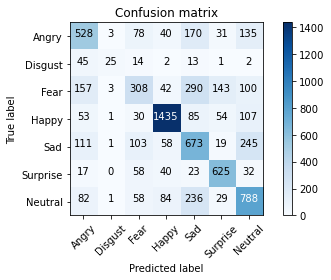

In [10]:
print('Predict CNN')
accuracy(predict_cnn)
ConfusionMatrix()


Predict SIFT_CNN
Accuracy on test set :62.17609361939259%
7178
7178
0.6217609361939259
[[ 551    3   77   51  105   37  161]
 [  46   25   18    2    6    4    1]
 [ 137    7  363   58  190  138  150]
 [  49    1   35 1481   49   38  112]
 [ 136    2  140   54  538   24  316]
 [  18    0   75   49   11  610   32]
 [  90    1   61   95  114   22  895]]


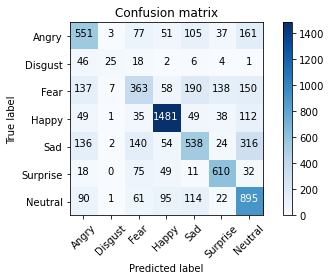

In [11]:
print('Predict SIFT_CNN')
accuracy(predict_scnn)
ConfusionMatrix()


Predict DSIFT_CNN
Accuracy on test set :24.630816383393704%
7178
7178
0.24630816383393703
[[   0    0    3  979    0    0    3]
 [   0    0    0  102    0    0    0]
 [   0    1    0 1036    0    2    4]
 [   0    0    0 1761    0    0    4]
 [   0    0    0 1204    0    0    6]
 [   0    1    1  788    0    2    3]
 [   0    0    2 1271    0    0    5]]


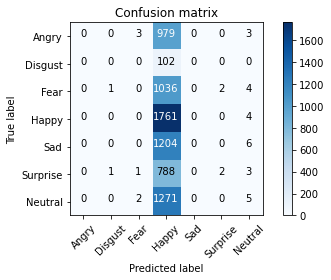

In [12]:
print('Predict DSIFT_CNN')
accuracy(predict_dcnn)
ConfusionMatrix()
